In [1]:
from salad.catalog import MultiEpochDetectionCatalog
import astropy.units as u
import astropy.table
import matplotlib.pyplot as plt
import numpy as np


In [2]:
catalog = MultiEpochDetectionCatalog.read("../catalog.pkl")

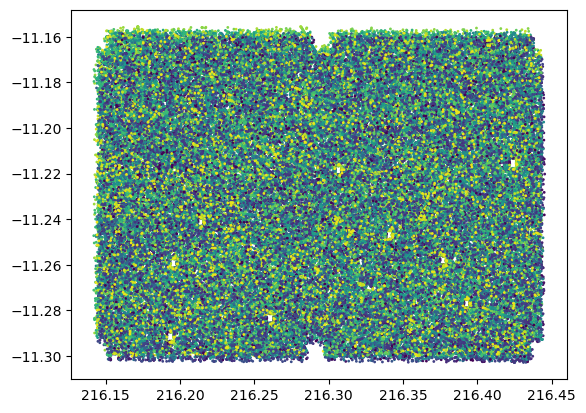

In [3]:
catalog = MultiEpochDetectionCatalog.read("../catalog.pkl")
X = catalog.X(sky_units=u.deg, time_units=u.day)
plt.scatter(X[:, 0], X[:, 1], c=X[:, 2], s=1)
plt.show()

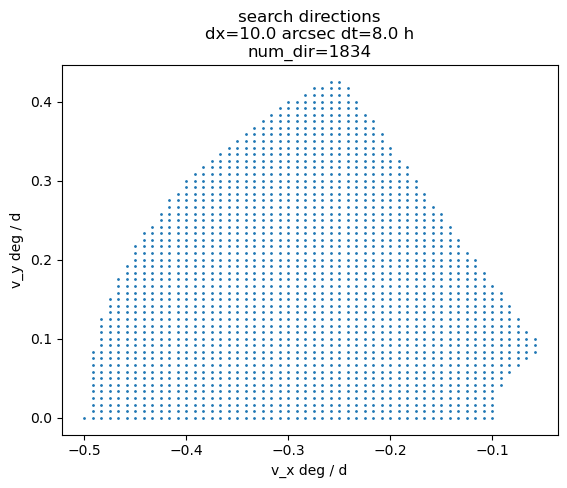

In [4]:

class SearchDirections():
    def __init__(self, velocity_range, angle_range, dx, dt):
        """
        specify two ranges and units
        """
        self.velocity_range = velocity_range
        self.angle_range = angle_range
        self.dx = dx
        self.dt = dt

    @property
    def v_min(self):
        return min(self.velocity_range)
    
    @property
    def v_max(self):
        return max(self.velocity_range)
        
    @property
    def phi_min(self):
        return min(self.angle_range)
    
    @property
    def phi_max(self):
        return max(self.angle_range)

        
    @property
    def b(self):
        if not hasattr(self, "_b"):
            _min = (-self.v_max * self.dt/self.dx).to(u.dimensionless_unscaled)
            _max = (self.v_max * self.dt/self.dx).to(u.dimensionless_unscaled)
            _v_x = np.arange(_min, _max + 1, 1)
            _v_y = np.arange(_min, _max + 1, 1)
            v_x_m, v_y_m = np.meshgrid(_v_x, _v_y)
            b = (np.vstack([v_x_m.flatten(), v_y_m.flatten()]).T * (dx/dt)).to(self.v_max.unit)
            _v = ((b**2).sum(axis=1)**0.5)
            _phi = np.arctan2(b[:, 1], b[:, 0])

            v_mask = (_v >= self.v_min) & (_v <= self.v_max)
            phi_mask = (_phi >= self.phi_min) & (_phi <= self.phi_max)
            b_m = b.reshape(len(_v_x), len(_v_y), 2)
            adjacent_dx_width = (b_m - np.roll(np.roll(b_m, 1, axis=0), 1, axis=1))[1:, 1:] * dt/dx
            assert(np.allclose(adjacent_dx_width[~np.isnan(adjacent_dx_width)], 1)) # all adjacent velocities are within 1 dx over timespan of dt
            self._b = b[v_mask & phi_mask]
        return self._b
                

        
sky_units = u.deg
time_units = u.day

velocity_units = sky_units / time_units
angle_units = u.deg
v = (0.1 * velocity_units, 0.5 * velocity_units)
phi = (120 * angle_units, 180 * angle_units)
dx = 10 * u.arcsec
dt = 8 * u.hour
directions = SearchDirections(
    v, phi,
    dx, dt,
)
plt.scatter(directions.b[:, 0], directions.b[:, 1], s=1)
plt.title("search directions\ndx=" +str(dx) + " dt=" + str(dt) + "\nnum_dir=" + str(directions.b.shape[0]))
plt.xlabel("v_x " + str(directions.b[0, 0].unit))
plt.ylabel("v_y " + str(directions.b[1, 0].unit))
plt.show()

In [5]:
_x.unit

NameError: name '_x' is not defined

In [6]:
_x = catalog.ra
_scale = (_x[0]*_x.unit / dx).to(u.dimensionless_unscaled)
print(_scale)
(max(_x) - min(_x)) * _scale

77811.55478497662


<Quantity 411.76863942>

In [7]:
((max(catalog.ra) - min(catalog.ra)) * catalog.ra.unit / dx).to(u.dimensionless_unscaled)

<Quantity 109.15265588>

In [8]:
(max(catalog.ra.to(u.hourangle) / dx) - min((catalog.ra.to(u.rad) / dx))).to(u.dimensionless_unscaled)

<Quantity 109.15265588>

In [13]:
import numba
import numpy as np

@numba.njit()
def xyz_to_xy_prime(x: np.ndarray, b: np.ndarray, reference_time: np.float64):
    vx = b[0]
    vy = b[1]
    x_prime = x[0] - vx * (x[2] - reference_time)
    y_prime = x[1] - vy * (x[2] - reference_time)
    return x_prime, y_prime

@numba.njit()
def digitize_point(p, min_x, min_y, dx, dy):
    return int((p[0] - min_x)/dx), int((p[1] - min_y)/dy)

@numba.njit(parallel=True)
def vote_points(hough: np.ndarray, X: np.ndarray, b: np.ndarray, x_min, y_min, dx, dy, reference_time, coef: np.float64=1):
    """
    Given detections vote in the hough space
    """
    n, d = X.shape
    num_b = b.shape[0]
    for b_idx in numba.prange(num_b): # for each direction
        if b_idx < num_b:
            b_i = b[b_idx]
            for i in range(n): # for each point
                x_prime, y_prime = xyz_to_xy_prime(X[i], b_i, reference_time)
                x_idx, y_idx = digitize_point(np.array([x_prime, y_prime]), x_min, y_min, dx, dy)
                if x_idx < hough.shape[1] and y_idx < hough.shape[2]:
                    hough[b_idx, x_idx, y_idx] += coef

@numba.njit(parallel=True)             
def vote_bins(hough: np.ndarray, bins: np.ndarray, coef: np.float64=1):
    """
    Given pre-binned detections vote in the hough space
    """
    num_b, n, _ = bins.shape
    for b_idx in numba.prange(num_b): # for each direction
        for i in range(n): # for each point
            if b_idx < num_b:
                x_idx = bins[b_idx, i, 0] # bin location for that point
                y_idx = bins[b_idx, i, 1]
                if x_idx < hough.shape[1] and y_idx < hough.shape[2]:
                    hough[b_idx, x_idx, y_idx] += coef

@numba.njit(parallel=True)
def transform_to_xy_prime(X: np.ndarray, b: np.ndarray, reference_time: np.float64):
    num_b = b.shape[0]
    n = X.shape[0]
    M = np.zeros((num_b, n, 2))
    for i in numba.prange(num_b):
        for j in range(n):
            M[i, j] = xyz_to_xy_prime(X[j], b[i], reference_time)
    return M

@numba.njit(parallel=True)
def digitize_xy(points, min_x, min_y, dx, dy):
    bins = np.zeros(points.shape, dtype=np.int32)
    for i in numba.prange(points.shape[0]):
        for j in range(points.shape[1]):
            x, y = digitize_point(points[i, j], min_x, min_y, dx, dy)
            bins[i, j, 0] = x
            bins[i, j, 1] = y
    return bins

@numba.njit()
def close_to_line(X, anchor, direction, dx, reference_time):
    M = transform_to_xy_prime(X, np.atleast_2d(direction), reference_time)[0]
    d = (anchor - M)
    d_norm = np.sum(d**2, axis=1)**0.5
    return d_norm <= dx


# directions.b.value

In [14]:
class Hough():
    def __init__(self, X, b, dx, dy, tolerance, precompute=True, dtype=np.int32):
        self.X = X
        self.b = b
        self.num_b = self.b.shape[0]
        self.min_x = X[:, 0].min()
        self.min_y = X[:, 1].min()
        self.min_z = X[:, 2].min()
        self.reference_time = self.min_z
        self.dx = dx
        self.dy = dy
        self.precompute = precompute
        self.n = len(X)
        self.tolerance = tolerance
        
        self.array = np.ndarray(self.shape, dtype=dtype)
        
        if self.precompute and (self.num_b * self.n <= 2**30):
            self.M = _numba_transform_to_xy_prime(self.X, self.b, self.reference_time)
            self.bins = _numba_digitize_xy(self.M, self.min_x, self.min_y, self.dx, self.dx)
            self.vote_method = "bins"
            self.vote_args = (self.bins,)
        else:
            self.M = None
            self.bins = None
            self.vote_method = "points"
            self.vote_args = (self.X, self.b, self.min_x, self.min_y, self.dx, self.dy, self.reference_time)

    
    def argmax(self):
        return np.unravel_index(self.array.argmax(), self.array.shape)
    
    def max(self):
        return self.array.max()
    
    @property
    def shape(self):
        if not hasattr(self, "_shape"):
            shape = [self.b.shape[0]]
            for i, w in enumerate([self.dx, self.dy]):
                _x = X[:, i]
                shape.append(int(((max(_x) - min(_x)) / w) + 1))
            self._shape = tuple(shape)
        return self._shape

    def vote(self, *args, mask=None, use_numba=True, **kwargs):
        if self.vote_method == "points":
            if use_numba:
                _vote = _numba_vote_points
            else:
                _vote = _vote_points
        elif self.vote_method == "bins":
            if use_numba:
                _vote = _numba_vote_bins
            else:
                _vote = _vote_bins

        if mask is not None:
            if self.vote_method == "bins":
                vote_args = (self.vote_args[0][:, mask],) + self.vote_args[1:]
            else:
                vote_args = (self.vote_args[0][mask],) + self.vote_args[1:]
        else:
            vote_args = self.vote_args
            
        return _vote(self.array, *vote_args, **kwargs)
    
    def anchor(self, x_idx, y_idx):
        x = ((x_idx + 1/2) * self.dx) + self.min_x
        y = ((y_idx + 1/2) * self.dy) + self.min_y
        return np.array([x, y])
        
    def voters(self, b_idx, x_idx, y_idx):
        m = _numba_transform_to_xy_prime(self.X, self.b[b_idx, None], self.reference_time)[0]
        bins = _numba_digitize_xy(m[None], self.min_x, self.min_y, self.dx, self.dy)[0]
        mask = (bins[:, 0] == x_idx) & (bins[:, 1] == y_idx)
        return mask
    
    def close(self, b_idx, x_idx, y_idx):            
        return _numba_close_to_line(self.X, self.anchor(x_idx, y_idx), self.b[b_idx], self.tolerance, self.reference_time)
    
#     @classmethod
#     def from_catalog(cls, catalog, columns, directions, widths):
#         X = catalog.X(columns=columns, sky_units=sky_units, time_units=time_units)
#         b = directions.b
#         num_b = b.shape[0]
#         shape = [b.shape[0]]
#         for c, w in zip(columns, widths):
#             _x = getattr(catalog, c)
#             shape.append(int(((max(_x) - min(_x))*_x.unit / w).to(u.dimensionless_unscaled) + 1))

#         return cls(tuple(shape), X, b)
    
#     @classmethod
#     def from_search(cls, X, b, widths):
#         num_b = b.shape[0]
#         shape = [b.shape[0]]
#         for i, w in enumerate(width):
#             _x = X[:, i]
#             shape.append(int(((max(_x) - min(_x)) / w) + 1))

#         return cls(tuple(shape), X, b)
    


In [15]:
hough.anchor(0, 1).shape

NameError: name 'hough' is not defined

In [16]:
hough = Hough(X, directions.b.value, dx.to(sky_units).value, dx.to(sky_units).value, dx.to(sky_units).value)
hough.vote()
plt.imshow(hough.array[hough.argmax()[0]])
plt.show()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mNameError: name 'xyz_to_xy_prime' is not defined[0m

In [192]:
b_idx, x_idx, y_idx = hough.argmax()
_close_to_line(hough.X, hough.anchor(x_idx, y_idx), hough.b[b_idx], hough.dx, hough.min_z)

array([False, False, False, ..., False, False, False])

In [194]:
idx = hough.argmax()
sum(hough.voters(*idx)), sum(hough.close(*idx))

(125, 165)

In [276]:
from sklearn.covariance import MinCovDet
import scipy

def mean_and_covar(z, robust=True):
    if robust:
        mcd = MinCovDet()
        mcd.fit(z)
        _mu = mcd.location_
        _covar = mcd.covariance_
    else:
        _mu = np.mean(z, axis=0)
        _covar = (z - _mu).T @ (z - _mu)
    return _mu, _covar

        

class RegressionResult():
    beta = None
    alpha = None
    outliers_r = None
    d_r = None
    outliers_x = None
    d_x = None
    sigma_e = None
    sigma_xx = None
    
    
def regression(x, y, robust=True):
#     logger.debug("solving regression problem x=%s -> y=%s", x.shape, y.shape)
    z = np.hstack([x, y])
    shift_z = - z.min(axis=0) / (z.max(axis=0) - z.min(axis=0))
    scale_z = 1 / (z.max(axis=0) - z.min(axis=0))
    A = np.diag(scale_z)
    inv_A = np.diag(1/scale_z)
    inv_A_T = inv_A
    b = shift_z
    z = z @ A + b

    _mu, _covar = mean_and_covar(z, robust=robust)
    
    mu = (_mu - b) @ inv_A
    covar = inv_A_T @ _covar @ inv_A

#     logger.debug("mu=%s", mu)
#     logger.debug("covar=%s", covar)

    mu_x = mu[:1]
    mu_y = mu[1:]

    sigma_xx = covar[:1, :1]
    sigma_xy = covar[:1, 1:]
    sigma_yy = covar[1:, 1:]

    beta = scipy.linalg.pinvh(sigma_xx) @ sigma_xy
    sigma_e = sigma_yy - beta.T @ sigma_xx @ beta
#     logger.debug("beta=%s", beta)
#     logger.debug("sigma_e=%s", sigma_e)
#     logger.debug("sigma_xx=%s", sigma_xx)
    # if np.any(sigma_e < 1e-12):
    #     logger.warning("clipping small (or negative values) in regression covariance matrix")
    #     sigma_e = np.clip(sigma_e, 1e-12, None)
    # if np.any(sigma_xx < 1e-12):
    #     logger.warning("clipping small (or negative values) in clustering covariance matrix")
    #     sigma_xx = np.clip(sigma_xx, 1e-12, None)

    alpha = mu_y - beta.T @ mu_x

    y_hat = x @ beta + alpha
    r = y - y_hat

    d_r = ((r @ scipy.linalg.pinvh(sigma_e) * r).sum(1))**0.5
    d_x = (((x - mu_x) @ scipy.linalg.pinvh(sigma_xx) * (x - mu_x)).sum(1))**0.5
#     logger.debug("d_r=%s", d_r)
#     logger.debug("d_x=%s", d_x)

    if np.any(np.isnan(d_r)):
        return None

    outliers_r = d_r > scipy.stats.chi.ppf(0.975, df=y.shape[1])
    outliers_x = d_x > scipy.stats.chi.ppf(0.975, df=x.shape[1])
    result = RegressionResult()
    result.beta = beta
    result.alpha = alpha
    result.outliers_r = outliers_r
    result.d_r = d_r
    result.outliers_x = outliers_x
    result.d_x = d_x
    result.sigma_e = sigma_e
    result.sigma_xx = sigma_xx
    return result
        

class SearchResult():
    votes = 0
    x_idx = None
    y_idx = None
    b_idx = None
    hough_anchor = None
    hough_dir = None
    voters = None
    close = None
    refined_anchor = None
    refined_dir = None
    refined = None
    regression_result = None
    
    
class Search():
    def __init__(self, hough):
        self.hough = hough
        self.mask = np.ones(hough.X.shape[0], dtype=bool)
    
    def refine(self, X, robust=True):
        regression_result = regression(X[:, 2][:, None], X[:, :2], robust=robust)
        if regression_result is not None:
            return np.atleast_1d(self.hough.reference_time) @ regression_result.beta + regression_result.alpha, regression_result.beta[0], regression_result
        else:
            return None, None, None
    
    
    def get_top_line(self, robust=True, refine_direction=True, refine_anchor=True):
        b_idx, x_idx, y_idx = self.hough.argmax()
        voters = self.hough.voters(b_idx, x_idx, y_idx) & self.mask
        hough_anchor = self.hough.anchor(x_idx, y_idx)
        hough_dir = self.hough.b[b_idx]
        close = _numba_close_to_line(self.hough.X, hough_anchor[None], hough_dir, self.hough.tolerance, self.hough.reference_time) & self.mask
        regression_result = None
        if refine_anchor and not refine_direction:
            # get the (robust) mean of the data points in the x' y' space
            xy = _numba_transform_to_xy_prime(self.hough.X[close], hough_dir[None], self.hough.reference_time)[0]
            _mu, _ = mean_and_covar(xy, robust=robust)
            refined_anchor = _mu[:2]
            refined_dir = hough_dir.copy()
        elif refine_anchor and refine_direction:
            # get the (robust) slope and (robust) intercept of a regression model
            # the new anchor is the position at the reference time using the (robust) slope and (robust) intercept
            # the new direction is the (robust) slope
            refined_anchor, refined_dir, regression_result = self.refine(self.hough.X[close], robust=robust)
            if refined_anchor is None:
                raise Exception("error in refinement")
        elif not refine_anchor and refine_direction:
            # the new direction is the (robust) slope
            # use the old anchor
            # undefined?
            raise Exception("can't refine direction and not the anchor")
        else:
            # do nothing
            refined_anchor = hough_anchor.copy()
            refined_dir = hough_dir.copy()
        
        refined = _numba_close_to_line(self.hough.X, refined_anchor[None], refined_dir[None], self.hough.dx, self.hough.reference_time) & self.mask
        result = SearchResult()
        result.votes = self.hough.max()
        result.b_idx = b_idx
        result.x_idx = x_idx
        result.y_idx = y_idx
        result.hough_anchor = hough_anchor
        result.hough_dir = hough_dir
        result.voters = voters
        result.close = close
        result.refined_anchor = refined_anchor
        result.refined_dir = refined_dir
        result.refined = refined
        result.regression_result = regression_result
        
        return result

    def __iter__(self):
        return self
    
    def __next__(self):
        search_result = self.get_top_line()
        self.hough.vote(mask=self.mask & search_result.refined, coef=-1)
        self.mask = self.mask & (~search_result.refined)
        return search_result
        
    def run(self, criteria):
        results = []
        for result in self:
            if criteria.should_stop(self, result, results):
                break
            else:
                results.append(result)
        return results

hough = Hough(X, directions.b.value, dx.to(sky_units).value, dx.to(sky_units).value, dx.to(sky_units).value)
hough.vote()

# hough = Hough.from_search(catalog, ["ra", "dec"], directions, [dx, dx])
# X = catalog.X(sky_units=sky_units, time_units=time_units)
search = Search(hough)


In [277]:
class Stopper():
    def should_stop(search, result, results):
        raise NotImplementedError()
        
class VoteThreshold(Stopper):
    def __init__(self, threshold):
        self.threshold = threshold
        
    def should_stop(self, search, result, results):
        if result.votes < self.threshold:
            return True
        else:
            return False

In [278]:
results = search.run(VoteThreshold(100))

In [289]:
results[0].regression_result.sigma_e

array([[ 5.84899394e-09, -1.90154238e-09],
       [-1.90154238e-09,  4.06643771e-09]])

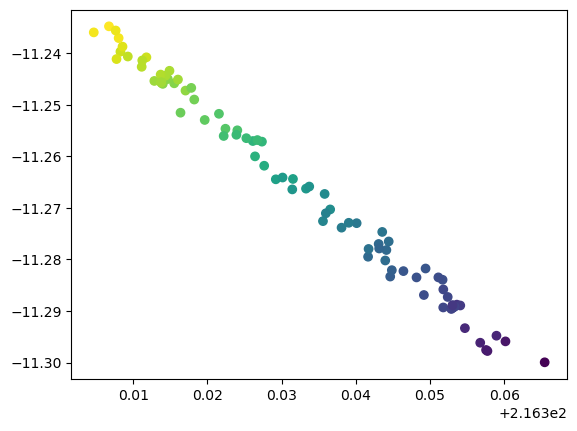

In [265]:
x = hough.X[results[-1].refined]
plt.scatter(x[:, 0], x[:, 1], c=x[:, 2])
plt.show()

In [ ]:
class SearchResult():
    def __init__(self, b, x, y):
        """
        
        """
    
    def voters(self, search: Search):
        """
        get the voters for this result given search
        """
        pass
    
    def close(self, search, tolerance=None):
        """
        get close detections for this result given search
        """
        if tolerance is None:
            tolerance = search.dx